## Import and settings

To run this notebook, install R and miselect and set up a PATH to Rscript.exe.

In this example, we need to import numpy, pandas, and matplotlib in addition to lingam.

In [1]:
import os
import sys

path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(path)

from prune_saenet import estimate_adj_matrix_for_stacked_imputed_datasets

import numpy as np
import pandas as pd

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
print([np.__version__, pd.__version__])

np.random.seed(100)

['1.24.4', '2.0.3']


## Test data

The following is the adjacency matrix for generating test datasets in this notebook.

In [2]:
m = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])
causal_order = [3, 0, 2, 1, 4, 5]

display(pd.DataFrame(m).style.background_gradient(axis=None))

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
1,0.565000,0.000000,0.377000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.991000,0.000000,-0.124000,0.000000,0.000000,0.000000
5,0.895000,0.000000,0.000000,0.000000,0.000000,0.000000


`estimate_adj_matrix_for_stacked_imputed_datasets` estimates an adjacency matrix based on the stacked datasets and its causal order. The following code generate a stacked dataset for this test run.

In [3]:
def generate_data(size=1000):
    scales = [0.2, 0.2, 0.2, 1, 0.2, 0.2]
    e = np.array([np.random.uniform(-np.sqrt(3 * scale), np.sqrt(3 * scale), size=size) for scale in scales])
    X = (np.linalg.pinv(np.eye(len(m)) - m) @ e).T
    return X

n_stacks = 3
X_list = [generate_data() for _ in range(n_stacks)]

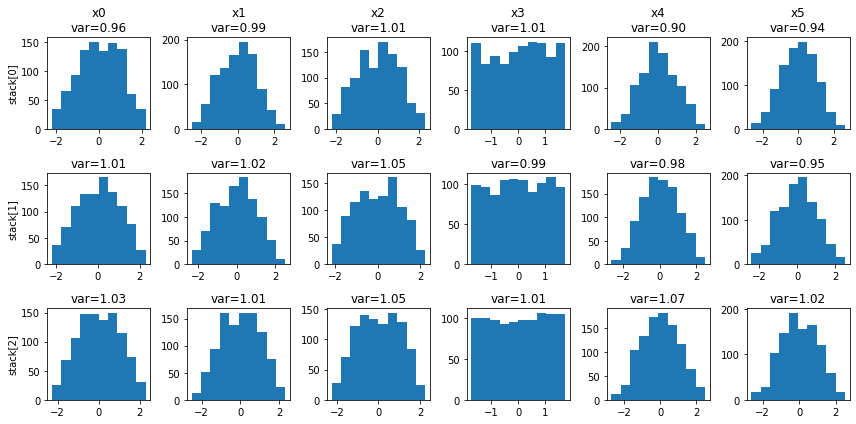

In [4]:
n_features = len(m)

fig, axes = plt.subplots(n_stacks, len(m), figsize=(2 * n_features, 2 * n_stacks))

for i, X in enumerate(X_list):
    for j in range(n_features):
        data = X_list[i][:, j]
        
        axes[i, j].hist(data)

        if i == 0:
            axes[i, j].set_title(f"x{j}\nvar={np.var(data):.2f}")
        else:
            axes[i, j].set_title(f"var={np.var(data):.2f}")
            
        if j == 0:
            axes[i, j].set_ylabel(f"stack[{i}]")

plt.tight_layout()
plt.show()

## Estimating adjacency matrix

In [5]:
adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(X_list, causal_order, seed=0)

The following is the estimated adjacency matrix.

In [6]:
pd.DataFrame(adj_mat).style.background_gradient(axis=None)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.852778,0.000000,0.000000
1,0.544589,0.000000,0.369132,0.025576,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.887313,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.938826,0.009709,-0.121985,0.032986,0.000000,0.000000
5,0.853060,0.008421,0.017566,0.000000,0.000000,0.000000


## Causal discovery on the dataset with missing data

To execute the following code, version 1.9.1 or later `lingam` package is required.

`lingam.tools.bootstrap_with_imputation` performs a causal discovery with `MultiGroupDirectLiNGAM` on the datasets generated by the multiple imputation to estimate the causal order, and then performs pruning on each of the datasets.

This section describes how to prune assuming a common pruning pattern on the datasets generated by multiple imputations.

In [7]:
# install lingam package
#%pip install "lingam>=1.9.1"

from lingam import MultiGroupDirectLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.tools import BaseMultiGroupCDModel, bootstrap_with_imputation
from lingam.utils import calculate_total_effect, print_causal_directions, print_dagc, make_dot

Insert some missing data into the test data.

In [8]:
# propotion of missing data for each variable
prop_missing = [0.05, 0, 0, 0, 0, 0]

X_miss = X.copy()
for i, prop in enumerate(prop_missing):
    mask = np.random.uniform(0, 1, size=len(X))
    X_miss[mask < prop, i] = np.nan

# actual proportion of missing data
np.sum(np.isnan(X_miss), axis=0) / len(X)

array([0.046, 0.   , 0.   , 0.   , 0.   , 0.   ])

`bootstrap_with_imputation` is performed to obtain estimation results.

In [9]:
# number of bootstrap sampling
n_sampling = 10
# number of multiple imputations
n_repeats = 10

# see the manual of lingam package for details of bootstrap_with_imputation
result = bootstrap_with_imputation(X_miss, n_sampling, n_repeats=n_repeats)

causal_orders, adj_matrices_list, resampled_indices, imputation_results = result

`n_sampling` causal orders and (`n_sampling` * `n_repeats`) adjacency matrices are estimated.

In [10]:
len(causal_order)

6

In [11]:
# (n_sampling, n_repeats, n_features, n_features)
adj_matrices_list.shape

(10, 10, 6, 6)

In multiple imputation, the results of the analysis for each of the multiple imputation are combined into a single result. However, in this result, `n_repeats` results are output as they are.

Use `estimate_adj_matrix_for_stacked_imputed_datasets` to estimate a single adjacency matrix from multiple imputation results. Create a causal discovery model using this function, pass it to the `cd_model` of `bootstrap_with_imputation`.

Define a class that `MultiGroupDirectLiNGAM` extends to use `estimate_adj_matrix_for_stacked_imputed_datasets` as follows:

In [12]:
class CustomizedMGCDModel(BaseMultiGroupCDModel):
    
    def __init__(self, ad_weight_type="min", prior_knowledge=None, apply_prior_knowledge_softly=False, random_state=None):
        self._model = MultiGroupDirectLiNGAM(
            prior_knowledge=prior_knowledge,
            apply_prior_knowledge_softly=apply_prior_knowledge_softly,
            random_state=random_state
        )

        self._ad_weight_type = ad_weight_type
        self._random_state = random_state
        
        self._weights = None

    def before_imputation(self, X):
        self._weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    def fit(self, X_list):
        self._model.fit(X_list)
        causal_order = self._model.causal_order_
        
        seed = None
        if self._random_state != None:
            seed = random_state.randint(0, 1e+4)
        
        adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(
            X_list,
            causal_order,
            ad_weight_type=self._ad_weight_type,
            weights=self._weights,
            seed=seed
        )

        return causal_order, adj_mat

Create an instance of the defined class and pass it to the `cd_model` argument of `bootstrap_with_imputation` and execute it.

In [13]:
cd_model = CustomizedMGCDModel()

result = bootstrap_with_imputation(X_miss, n_sampling, n_repeats, cd_model=cd_model)

causal_orders, adj_list, resampled_indices, imputation_results = result

The shape of `adj_matrices_list` is `(n_sampling, n_repeats, n_features, n_features)`, but by giving `CustomizedMGCDModel` to `cd_model`, `adj_list` is `(n_sampling, n_ features, n_features)`. This is because one adjacency matrix is now estimated for each `n_repeats` dataset obtained when performing a multiple imputation.

In [14]:
adj_list.shape

(10, 6, 6)

The `adj_list` will hold the bootstrap results of `n_sampling` times. To visualize the results of the bootstrap, execute the following code.

For more information on `lingam.bootstrap.BootstrapResult`, check the `lingam` [manual](https://lingam.readthedocs.io/en/stable/reference/bootstrap.html) and [samples](https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py).

In [15]:
# calculate total effect
total_effect = np.zeros(adj_list.shape)
for i, (causal_order, adj) in enumerate(zip(causal_orders, adj_list)):
    for j, from_ in enumerate(causal_order):
        for to in causal_order[j + 1 :]:
            eff = calculate_total_effect(adj, from_, to)
            total_effect[i, to, from_] = eff

bs_result = BootstrapResult(adj_list, total_effect)

### Causal directions

In [16]:
cdc = bs_result.get_causal_direction_counts()

print_causal_directions(cdc, n_sampling=len(adj_list))

x0 <--- x3  (100.0%)
x1 <--- x0  (100.0%)
x1 <--- x2  (100.0%)
x2 <--- x3  (100.0%)
x5 <--- x0  (100.0%)
x4 <--- x0  (100.0%)
x4 <--- x2  (100.0%)
x1 <--- x3  (90.0%)
x1 <--- x4  (60.0%)
x5 <--- x1  (60.0%)
x5 <--- x3  (50.0%)
x0 <--- x2  (40.0%)
x5 <--- x2  (30.0%)
x4 <--- x5  (20.0%)
x1 <--- x5  (10.0%)
x4 <--- x1  (10.0%)
x2 <--- x5  (10.0%)


### Directed acyclic graphs

In [17]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3)
print_dagc(dagc, n_sampling=len(adj_list))

DAG[0]: 20.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x1 <--- x3 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x5 <--- x0 
	x5 <--- x1 
	x5 <--- x3 
DAG[1]: 10.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x1 <--- x3 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x1 
	x4 <--- x2 
	x4 <--- x5 
	x5 <--- x0 
	x5 <--- x1 
	x5 <--- x3 
DAG[2]: 10.0%
	x0 <--- x3 
	x1 <--- x0 
	x1 <--- x2 
	x1 <--- x3 
	x1 <--- x4 
	x2 <--- x3 
	x4 <--- x0 
	x4 <--- x2 
	x4 <--- x5 
	x5 <--- x0 
	x5 <--- x2 


### Probability

In [18]:
prob = bs_result.get_probabilities(min_causal_effect=0.01)
prob

array([[0. , 0. , 0.3, 1. , 0. , 0. ],
       [1. , 0. , 1. , 0.9, 0.6, 0.1],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0.1, 1. , 0. , 0. , 0.2],
       [1. , 0.5, 0.2, 0.5, 0. , 0. ]])

### Total causal effects

In [19]:
causal_effects = bs_result.get_total_causal_effects(min_causal_effect=0.01)
pd.DataFrame(causal_effects).sort_values("effect", key=abs, ascending=False).head()

,from,to,effect,probability
0,0,4,0.998464,1.0
4,3,2,0.900022,1.0
9,3,0,0.863544,1.0
1,0,5,0.827920,1.0
6,3,1,0.812799,1.0


### Bootstrap probability of path

In [20]:
from_index = 3 # index of x3
to_index = 1 # index of x0

pd.DataFrame(bs_result.get_paths(from_index, to_index)).sort_values("effect", key=abs, ascending=False).head()

,path,effect,probability
0,"[3, 0, 1]",0.423491,1.0
1,"[3, 2, 1]",0.301661,1.0
2,"[3, 1]",0.071709,0.9
3,"[3, 0, 4, 1]",0.018719,0.6
7,"[3, 0, 5, 1]",0.016159,0.1
